## Setup Requirements

In [8]:
!{sys.executable} -m pip install virustotal3
!{sys.executable} -m pip install python-dotenv
!{sys.executable} -m pip install pandas

You should consider upgrading via the '/usr/local/Cellar/ipython/8.2.0/libexec/bin/python3.10 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/ipython/8.2.0/libexec/bin/python3.10 -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 8.6 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.5/503.5 KB 8.2 MB/s eta 0:00:0031m11.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/Cellar/ipython/8.2.0/libexec/bin/python3.10 -m pip install --upgrade pip' command.


In [12]:
import json
import virustotal3.core as vt3core
from dotenv import load_dotenv
import os
import csv
import time
import datetime
import sys

sys.path.append('/Users/bikram/tools/internal/mymodules')
load_dotenv('/Users/bikram/tools/internal/mymodules/.env')

VT_API = os.getenv('VT_API')
vtcore_files = vt3core.Files(VT_API)
vtcore_domains = vt3core.Domains(VT_API)

collected_data_dir = './collected_data'
input_file = './indicators.csv'
timeline_csv = './timeline.csv'
dates = []
with open(timeline_csv, 'w+') as timeline_file:
    timeline_writer = csv.writer(timeline_file)
    timeline_writer.writerow(['Value', 'Type', 'Date'])


## Get Data from VirusTotal

In [13]:
# Read indicator records from input CSV file
csv_file = open(input_file, 'r')
csv_file_records = csv.DictReader(csv_file)

for record in csv_file_records:
    record_type = record['Type']
    record_value = record['Value']
    
    record_out_path = '{0}/{1}.json'.format(collected_data_dir, record_value)
    
#     print("Getting data from VirusTotal for " + record_value)

    # Query VT and save indicator info if data does not exist
    if(os.path.exists(record_out_path) == False):
        
        if(record_type == 'File'):
            record_info = vtcore_files.info_file(record_value)
        elif(record_type == 'Host'):
            record_info = vtcore_domains.info_domain(record_value)
        
        with open(record_out_path, 'w+') as out_data:
            out_data.write(json.dumps(record_info, indent=2))

    # Parse indicator data file for dates
    with open(record_out_path) as record_file:
        record_info_all = json.loads(record_file.read())
        record_info_data = record_info_all['data']['attributes']

        # Add dates for indicator to timeline file
        with open(timeline_csv, 'a+') as timeline_file:
            timeline_writer = csv.writer(timeline_file)
            
            if('creation_date' in record_info_data):
                creation_date = datetime.datetime.fromtimestamp(record_info_data['creation_date'])
                timeline_writer.writerow([record_value, 'Creation Date', creation_date])
            
            if('last_modification_date' in record_info_data):
                modification_date = datetime.datetime.fromtimestamp(record_info_data['last_modification_date'])
                timeline_writer.writerow([record_value, 'Last Modification Date', modification_date])
            
            if(record_type == 'File'):
                submission_date = datetime.datetime.fromtimestamp(record_info_data['first_submission_date'])
                timeline_writer.writerow([record_value, 'First Submission Date', submission_date])

    # time.sleep(60)
                    
csv_file.close()

## Print Saved Dates

In [17]:
import pandas as pd

df = pd.read_csv(timeline_csv, sep=",")
df['Date'] = pd.to_datetime(df['Date'])
# mask = df['Type'].isin(['First Submission Date', 'Last Modification Date'])
# df = df[~mask]
df.sort_values(by=['Date'])
# df

,Value,Type,Date
54,3ce796e218e0a4fffd43fb91f1d2a806,Creation Date,2018-01-07 04:25:00
33,3532a97cd9a322d1423c56eb24000939,Creation Date,2018-01-07 04:25:00
60,f11fb84e8ea1b63d9771c8199d85a268,Creation Date,2018-01-07 04:25:00
51,cb1e8abeb5d512b4bce67776dbaa1f2f,Creation Date,2018-01-07 04:25:00
42,d7ae926c681b7cfdc62c6bf530317f07,Creation Date,2018-01-07 04:25:00
...,...,...,...
82,0edba804b993b1f98a7b8e891e90d07d,Last Modification Date,2022-02-07 15:02:34
52,cb1e8abeb5d512b4bce67776dbaa1f2f,Last Modification Date,2022-02-07 15:04:10
61,f11fb84e8ea1b63d9771c8199d85a268,Last Modification Date,2022-02-07 15:14:14
43,d7ae926c681b7cfdc62c6bf530317f07,Last Modification Date,2022-02-07 19:21:04


### Graph by Time of Day

<AxesSubplot:xlabel='Time'>

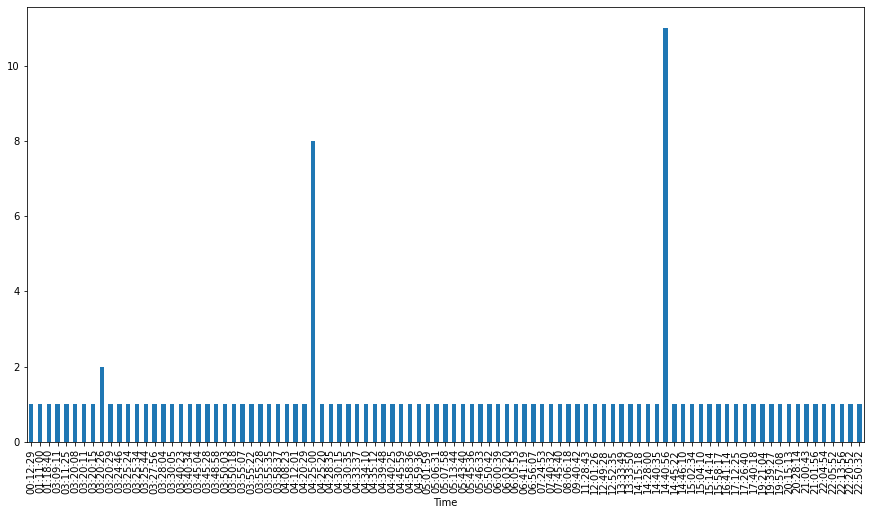

In [18]:
without_date = df['Date'].apply( lambda d : d.time() )
df['Time'] = without_date
df.groupby(['Time']).count()['Value'].plot(kind='bar', figsize=[15,8])

### Graph by Date

<AxesSubplot:xlabel='Date_notime'>

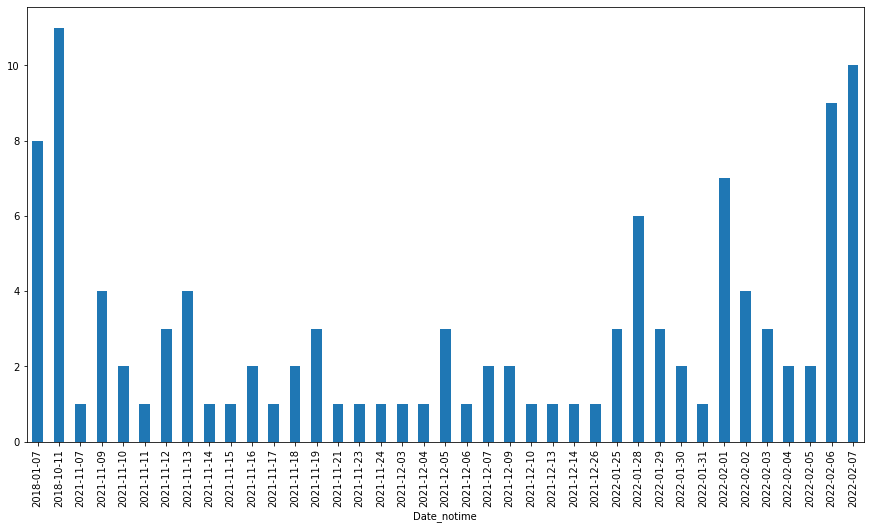

In [19]:
without_time = df['Date'].apply( lambda d : d.date() )
df['Date_notime'] = without_time
df.groupby(['Date_notime']).count()['Value'].plot(kind='bar', figsize=[15,8])

### Graph by Weekday

<AxesSubplot:xlabel='Weekday'>

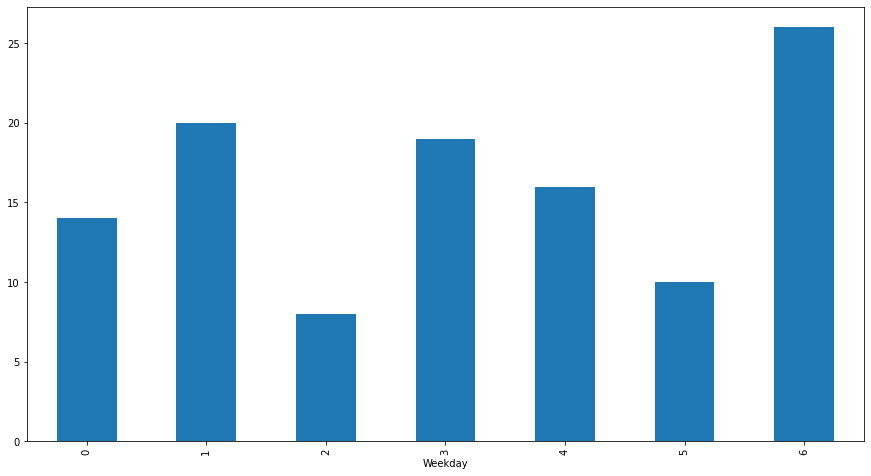

In [20]:
without_time = df['Date'].apply( lambda d : d.weekday() )
df['Weekday'] = without_time
df.groupby(['Weekday']).count()['Value'].plot(kind='bar', figsize=[15,8])

### Graph by Month

<AxesSubplot:xlabel='Month'>

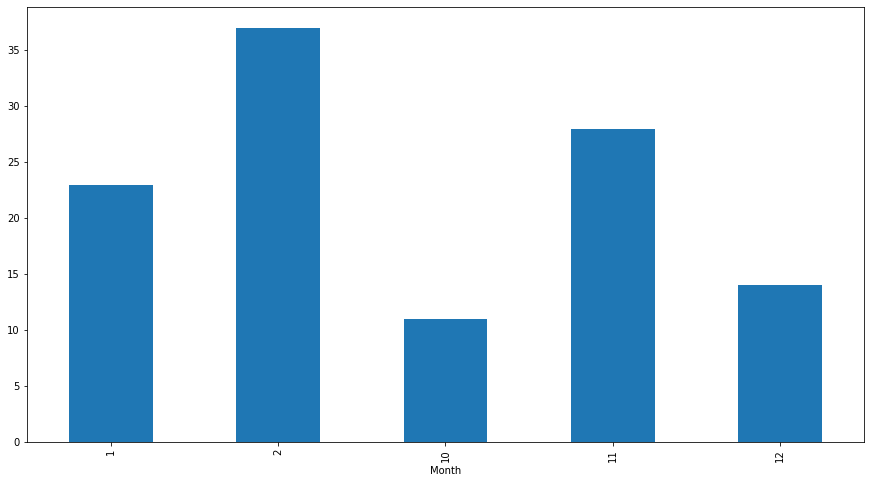

In [21]:
df['Month'] = pd.DatetimeIndex(df['Date']).month
df.groupby(['Month']).count()['Value'].plot(kind='bar', figsize=[15,8])